#### Analyzing the impact of convolution + pooling on images

In [1]:
import numpy as np

In [2]:
from tensorflow.keras import datasets, models, layers, optimizers

#### CIFAR10 dataset || Extracting Images

In [3]:
# Downloading the data and storing it in test/train datasets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [4]:
img=x_train[11,] #--Extracting the 11th image from the dataset which is a man riding on a horse

In [5]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

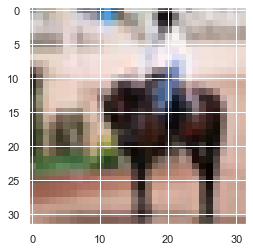

In [6]:
plt.imshow(img)

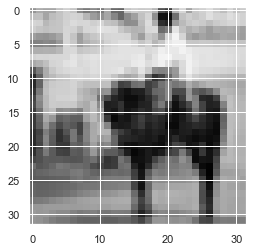

In [7]:
# Convert image to grayscale. The second argument in the following step is cv2.COLOR_BGR2GRAY, which converts colour image to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

#### Storing grayscale values in an array

In [9]:
data=np.array(gray)
data.shape

(32, 32)

Setting the shape as 28, 28, 1 denoting it as grayscale 

In [10]:
data = data.reshape(data.shape[0],data.shape[1],1)

In [11]:
data.shape

(32, 32, 1)

#### Defining Filters of 3*3 size to use for convolutions

In [43]:
filter_1 = np.array([[1, 1, 1], [-1, 2, 1], [-1, -1, -1]])

In [44]:
filter_1.shape

(3, 3)

#### Adding 3 verisons of the above filters

In [61]:
filter_2 = -filter_1 #---Negative of the original filter
filter_3 = filter_1.T #--Transpose of Original filter
filter_4 = -filter_3 #---Negative of the transposed filter

#### Collating the filters into one list

In [51]:
filter_all=[filter_1,filter_2,filter_3,filter_4]

## Implementing convolution

In [102]:
def process(data=None, filterArray=None, stride=1, process_name='conv', padding_size=0):
    """
    Method can be used to do 
        convolution based on filter provided
        max pooling
        average pooling
    """
    
    if padding_size>0:
#         print(f"Adding padding")
        data = addPadding(data, padding_size=padding_size)
    
    #---Initializing the Dimension of the Image
    
    filter_row_size = filterArray.shape[0]
    filter_col_size = filterArray.shape[1]

    max_rowIdx = data.shape[0]
    max_colIdx = data.shape[1]

    
    expected_outcome_row_size = (max_rowIdx - filter_row_size)/stride + 1
    expected_outcome_col_size = (max_colIdx - filter_col_size)/stride + 1

    expected_outcome_row_size = np.floor(expected_outcome_row_size).astype(int)
    expected_outcome_col_size = np.floor(expected_outcome_col_size).astype(int)
    
    convoluted_values = []
    
#     print(f"Input data shape = {data.shape}")
#     print(f"Filter size = {filterArray.shape}")
#     print(f"Stride = {stride}")
#     print(f"Expected output size = ({expected_outcome_row_size}, {expected_outcome_col_size})")
    
    #Iterating for every row with step as the Stride
    for rowIdx in np.arange(0, data.shape[0], stride):
                
        conv_area_row_min = rowIdx
        conv_area_row_max = rowIdx + (filter_row_size)

        if conv_area_row_max <= max_rowIdx:        
            #Iterating for every col with ste as the Stride
            for colIdx in np.arange(0, data.shape[1], stride):
                
                conv_area_col_min = colIdx
                conv_area_col_max = colIdx + (filter_col_size)

                if conv_area_col_max <= max_colIdx:

                    curr_conv_area = data[conv_area_row_min:conv_area_row_max, conv_area_col_min:conv_area_col_max]
                    if process_name=='conv':
                        convoluted_value = np.sum(np.multiply(curr_conv_area, filterArray))
                        
#                     elif process_name=='max_pooling':
#                         convoluted_value = np.max(curr_conv_area)
#                     elif process_name=='avg_pooling':
#                         convoluted_value = np.average(curr_conv_area)
                    else:
                        print("Unsupported operation")
                        return null
                    convoluted_values.append(convoluted_value)
                    
    convoluted_values = np.array(convoluted_values).reshape(expected_outcome_row_size, expected_outcome_col_size)
    return convoluted_values


In [103]:
def pooling(data, stride, size, pooling_type):
    
    """
    Function to implement pooling on a gray scale image. 
    Note: The function works with n x n filter to produce the pooling results
    """    
    
    #-----Dimension of the Convolved Matrix/Activation Map/Feature Map
    max_rowIdx = data.shape[0]
    max_colIdx = data.shape[1]
    
    #----Expected Output post Pooling
    expected_outcome_row_size = np.floor((max_rowIdx - size)/stride + 1).astype(int)
    expected_outcome_col_size = np.floor((max_colIdx - size)/stride + 1).astype(int)
    
    #---List to store the values after pooling
    pooled_values=[]
    
    for rowIdx in np.arange(0, data.shape[0], stride):
                
        pool_area_row_min = rowIdx
        pool_area_row_max = rowIdx + (size)
        
        if pool_area_row_max <= max_rowIdx: 
            
            #Iterating for every col with ste as the Stride
            for colIdx in np.arange(0, data.shape[1], stride):
                
                pool_area_col_min = colIdx
                pool_area_col_max = colIdx + (size)

                if pool_area_col_max <= max_colIdx:

                    curr_pool_area = data[pool_area_row_min:pool_area_row_max, pool_area_col_min:pool_area_col_max]
                    
                    if pooling_type=='max_pooling':
                        pooled_value = np.max(curr_pool_area)
                    elif pooling_type=='avg_pooling':
                        pooled_value = np.average(curr_pool_area)
                    else:
                        print("Unsupported operation")
                        return null
                    
                    pooled_values.append(pooled_value)
                    
    pooled_values = np.array(pooled_values).reshape(expected_outcome_row_size, expected_outcome_col_size)
    return pooled_values
        
    

In [104]:
def addPadding(data, padding_size=1):
    
#     print(f"Input data shape {data.shape}")
    actual_data_row_size = data.shape[0]
    actual_data_col_size = data.shape[1]
    
    padded_data = np.zeros((actual_data_row_size + 2*padding_size, actual_data_col_size + 2*padding_size))
    
    for rowIdx in range(padded_data.shape[0]):
        if rowIdx >=padding_size and rowIdx<=actual_data_row_size:
            for colIdx in range(padded_data.shape[1]):
                if colIdx >= padding_size and colIdx<=actual_data_col_size:
                    padded_data[rowIdx][colIdx] = data[rowIdx-padding_size][colIdx-padding_size]
                    
    padded_data = padded_data.reshape(padded_data.shape[0], padded_data.shape[1], 1)
#     print(f"Padded data array shape {padded_data.shape}")
    return padded_data
        

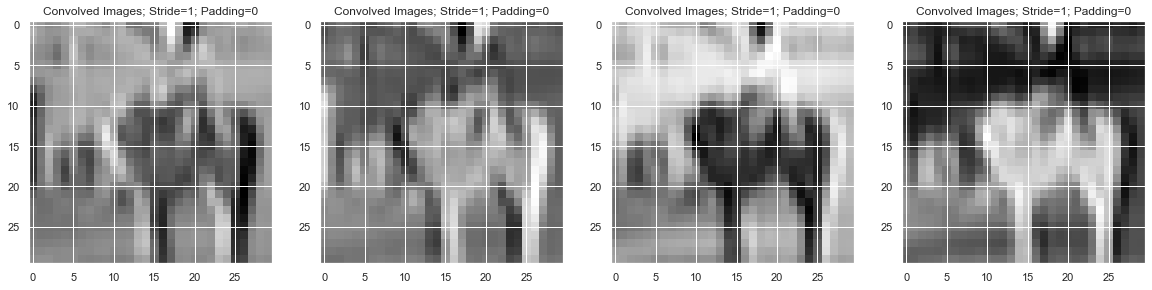

In [105]:
plt.figure(figsize=(20,15))

for i in range(1,5):
    conv = process(data=data, filterArray=filter_all[i-1], stride=1, process_name='conv', padding_size=0)
    x=conv.shape[0]
    conv=conv.reshape(x,x)
    plt.subplot(1,4,i)
    plt.title("Convolved Images; Stride=1; Padding=0")
    plt.imshow(conv, cmap='gray')

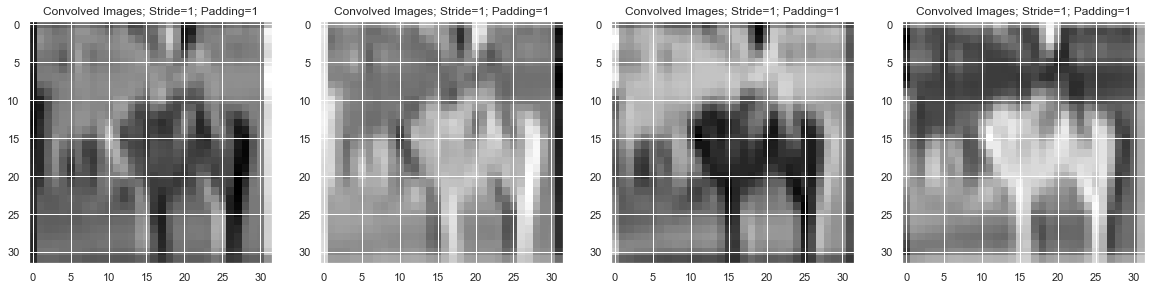

In [123]:
plt.figure(figsize=(20,15))

for i in range(1,5):
    conv = process(data=data, filterArray=filter_all[i-1], stride=1, process_name='conv', padding_size=1)
    conv = process(data=data, filterArray=filter_all[i-1], stride=1, process_name='conv', padding_size=1)
    x=conv.shape[0]
    conv=conv.reshape(x,x)
    plt.subplot(1,4,i)
    plt.title("Convolved Images; Stride=1; Padding=1")
    plt.imshow(conv, cmap='gray')

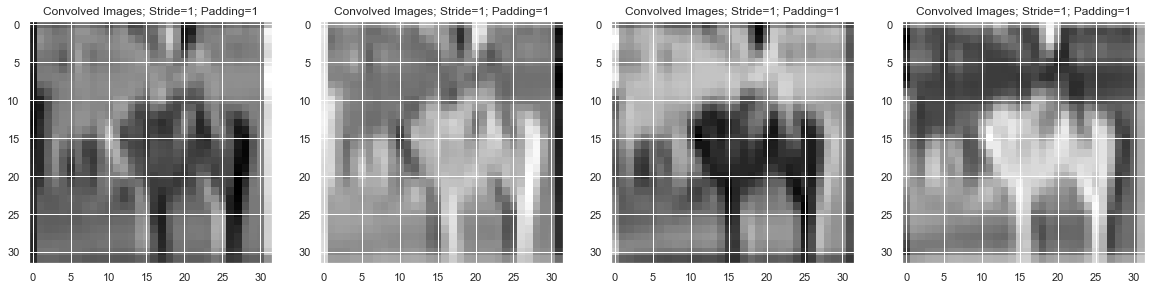

In [106]:
plt.figure(figsize=(20,15))

for i in range(1,5):
    conv = process(data=data, filterArray=filter_all[i-1], stride=1, process_name='conv', padding_size=1)
    x=conv.shape[0]
    conv=conv.reshape(x,x)
    plt.subplot(1,4,i)
    plt.title("Convolved Images; Stride=1; Padding=1")
    plt.imshow(conv, cmap='gray')

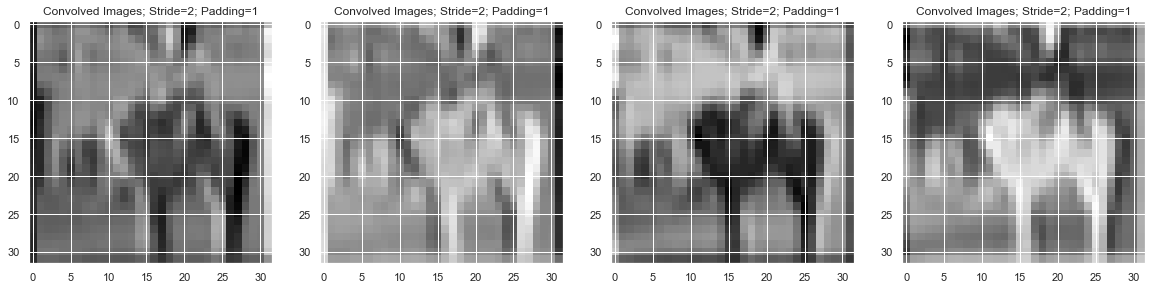

In [115]:
plt.figure(figsize=(20,15))

for i in range(1,5):
    conv = process(data=data, filterArray=filter_all[i-1], stride=1, process_name='conv', padding_size=1)
    x=conv.shape[0]
    conv=conv.reshape(x,x)
    plt.subplot(1,4,i)
    plt.title("Convolved Images; Stride=2; Padding=1")
    plt.imshow(conv, cmap='gray')

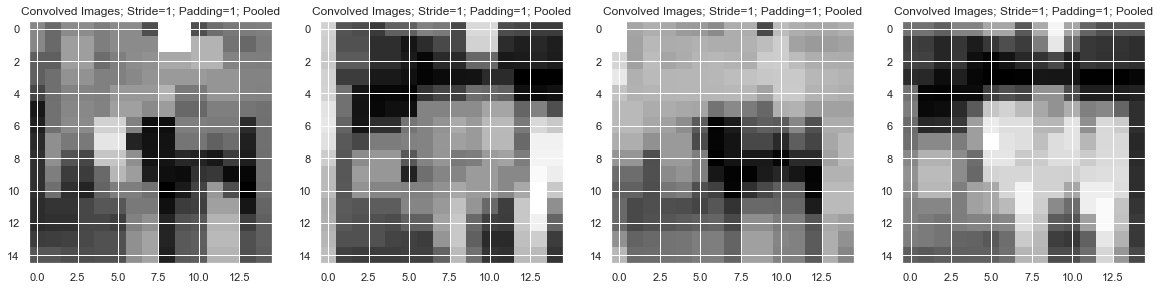

In [119]:
plt.figure(figsize=(20,15))

for i in range(1,5):
    conv = process(data=data, filterArray=filter_all[i-1], stride=1, process_name='conv', padding_size=1)
    pool=pooling(data=conv,stride=2,size=3,pooling_type='max_pooling')
    x=pool.shape[0]
    pool=pool.reshape(x,x)
    plt.subplot(1,4,i)
    plt.title("Convolved Images; Stride=1; Padding=1; Pooled")
    plt.imshow(pool, cmap='gray')